## Expressivity in Musical Timing

#### EXPERIMENT 1-00

This is the initial experiment comparing two recordings of *Mi Refugio* by *Troilo*.

Recordings compared are:
  * A. Troilo y R. Grela (1955)
  * Quinteto A. Troilo (1958)
  
Sections compared are A (16 bars) and B (20 bars) for a total of 36 bars.


### How to run the notebook

You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/troilo/blob/main/notebooks/experiment-1-A.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

#### Install carat package

In [ ]:
!git clone --branch tempo https://github.com/mrocamora/carat.git --single-branch

In [ ]:
!pip install ./carat/

#### Import required packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from carat import util
from carat import tempo
from carat import display
from carat import annotations

#### Download annotation files
Download annotations files to work with from zenodo.

In [2]:
!mkdir data
!wget -P ./data/ https://zenodo.org/record/4648528/files/A.%20Troilo%20y%20R.%20Grela%20%281955%29%20-%20Mi%20refugio%20%28A-B%29%20-%20Beats.csv
!wget -P ./data/ https://zenodo.org/record/4648528/files/Quinteto%20A.%20Troilo%20%281958%29%20-%20Mi%20refugio%20%28A-B%29%20-%20Beats.csv

--2021-11-12 16:34:16--  https://zenodo.org/record/4648528/files/A.%20Troilo%20y%20R.%20Grela%20%281955%29%20-%20Mi%20refugio%20%28A-B%29%20-%20Beats.csv
Resolviendo zenodo.org (zenodo.org)... 137.138.76.77
Conectando con zenodo.org (zenodo.org)[137.138.76.77]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 2557 (2,5K) [text/plain]
Guardando como: “./data/A. Troilo y R. Grela (1955) - Mi refugio (A-B) - Beats.csv”

A. Troilo y R. Grel 100%[===================>]   2,50K  --.-KB/s    en 0s      

2021-11-12 16:34:18 (119 MB/s) - “./data/A. Troilo y R. Grela (1955) - Mi refugio (A-B) - Beats.csv” guardado [2557/2557]

--2021-11-12 16:34:19--  https://zenodo.org/record/4648528/files/Quinteto%20A.%20Troilo%20%281958%29%20-%20Mi%20refugio%20%28A-B%29%20-%20Beats.csv
Resolviendo zenodo.org (zenodo.org)... 137.138.76.77
Conectando con zenodo.org (zenodo.org)[137.138.76.77]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 2556 (2,

In [3]:
# set name of the data folder and annotation files
filename_suffix = '.csv'
data_folder = 'data'
music_name = 'Mi refugio'
recordings = ['A. Troilo y R. Grela (1955)', 
              'Quinteto A. Troilo (1958)']
filename_class = " (A-B) - Beats"

In [4]:
# set initial bar for each recording
ini_bars = [1, 1]
# set number of bars for each recording
num_bars = [37, 37]

In [5]:
# timing data information for each music recording
timing_data = []

# process each recording
for ind, base_filename in enumerate(recordings):
    
    # read annotations from file
    annotations_file = os.path.join(data_folder, 
                                    base_filename + " - " + music_name + filename_class + filename_suffix)
      
    # load beats and beat labels
    beats, beat_labs = annotations.load_beats(annotations_file)
    # load downbeats and downbeat labels
    downbeats, downbeat_labs = annotations.load_downbeats(annotations_file)
    
    # trim beats 
    beats, beat_labs = annotations.trim_beats(beats, beat_labs, downbeats, ini_bars[ind], num_bars[ind])
    # trim downbeats
    downbeats, downbeat_labs = annotations.trim_downbeats(downbeats, downbeat_labs, ini_bars[ind], num_bars[ind])
    
    # compute bpm curve (from beat annotations)
    bpms = tempo.compute_tempo_values(beats)
    # smooth bpm curve
    bpms_smooth = tempo.smooth_tempo_curve(bpms)
    

    # create dictionary for current recording
    recording = {"name": base_filename,
                 "beats": beats,
                 "beat_labs": beat_labs,
                 "downbeats": downbeats,
                 "downbeat_labs": downbeat_labs,
                 "bpms": bpms,
                 "bpms_smooth": bpms_smooth
                }
    # save dictionary
    timing_data.append(recording)


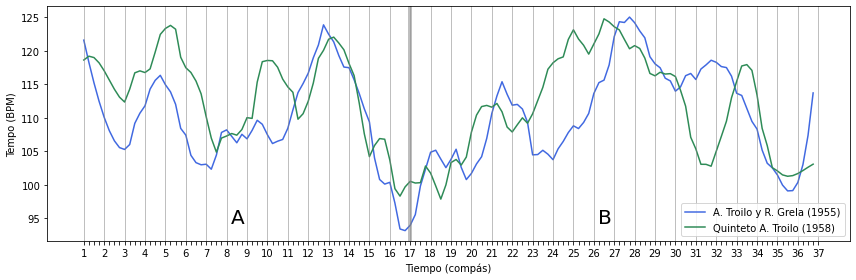

In [6]:
# plot tempo curves
colors = ['royalblue', 'seagreen']
plt.figure(figsize=(12,4))

for ind, recording in enumerate(timing_data):
        if ind == 0:
            ax = display.tempo_curve_plot(recording["bpms_smooth"], recording["beat_labs"], 
                                          label=recording["name"], color=colors[ind])
        else:
            ax = display.tempo_curve_plot(recording["bpms_smooth"], recording["beat_labs"], ax=ax,
                                          label=recording["name"], color=colors[ind])

plt.legend(loc='lower right')
plt.xlabel('Tiempo (compás)')
plt.ylabel('Tempo (BPM)')
plt.axvline(x=16*4, linewidth=4, color='gray', alpha=0.5)
plt.text(0.237, 0.10, 'A', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes)
plt.text(0.695, 0.10, 'B', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes)
for ind, x in enumerate(recording["beat_labs"]):
    if '.1' in x:
        plt.axvline(x=ind, linewidth=1, color='gray', alpha=0.5)

plt.tight_layout()

In [7]:
# compute correlation matrix
recording1 = timing_data[0]
recording2 = timing_data[1]
data1 = recording1["bpms_smooth"]
data2 = recording2["bpms_smooth"]
CM = util.compute_correlation_matrix(data1, data2)

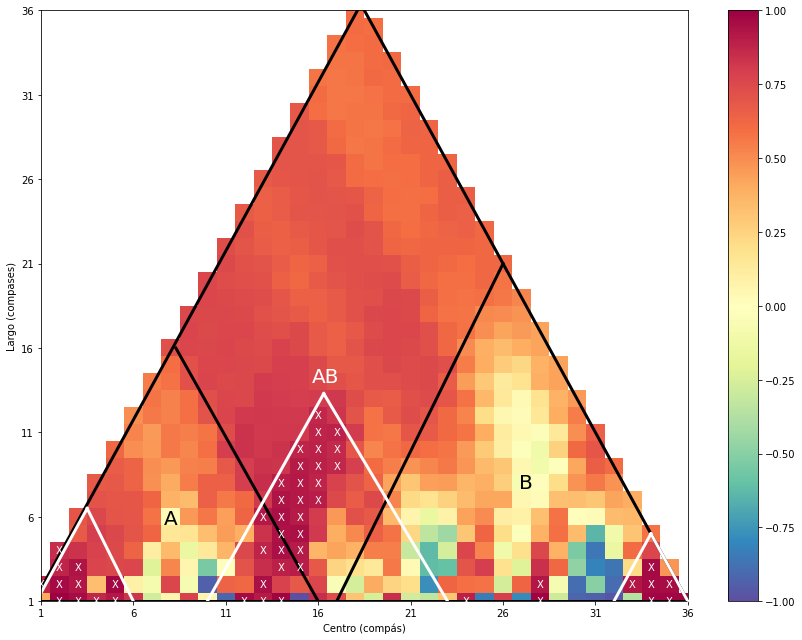

In [8]:
# plot scape plot for the correlation matrix
plt.figure(figsize=(12,9))

ax, im = display.scape_plot(CM, thr=0.85, xlabel='Centro (compás)', ylabel='Largo (compases)')

# A and B sections
plt.plot([15, 7.3], [0, 15], '-', linewidth=3, color='black')
plt.plot([16, 25], [0, 20], '-', linewidth=3, color='black')
# AB section
plt.plot([9, 15.3], [0, 12.3], '-', linewidth=3, color='white')
plt.plot([15.3, 22], [12.3, 0], '-', linewidth=3, color='white')
# initial section
plt.plot([-0.25, 2.5], [0, 5.5], '-', linewidth=3, color='white')
plt.plot([2.5, 5], [5.5, 0], '-', linewidth=3, color='white')
# ending section
plt.plot([31, 33], [0, 4], '-', linewidth=3, color='white')
plt.plot([33, 35], [4, 0], '-', linewidth=3, color='white')


plt.text(0.20, 0.14, 'A', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes)
plt.text(0.75, 0.20, 'B', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes)
plt.text(0.44, 0.38, 'AB', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes, color='white')

plt.colorbar(im) 
plt.tight_layout()

In [9]:
# first downbeat of part B
ini = 16*4
# interpolation data
interpoly_data = []

for recording in timing_data:
    
    bpms = recording["bpms_smooth"]
    y = bpms[ini:]
    x = np.arange(len(y)) + ini
    
    # transforming the data to include another axis
    x = x[:, np.newaxis]
    y = y[:, np.newaxis]
    
    # polynomial feature transformation
    poly_reg = PolynomialFeatures(degree=2)
    x_poly = poly_reg.fit_transform(x)
    
    # linear regression
    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    
    # compute rmse and coefficient of determination
    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    
    # create dictionary for current recording
    poly_data = {"x_poly": x,
                 "y_poly": y_poly_pred,
                 "rmse": rmse,
                 "r2": r2
                }
    # save dictionary
    interpoly_data.append(poly_data)

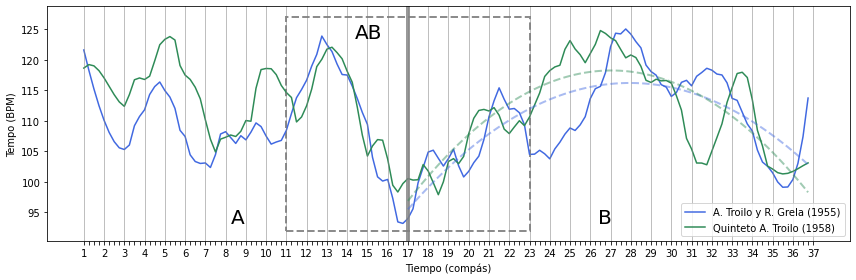

In [10]:
# plot tempo curves
colors = ['royalblue', 'seagreen']
plt.figure(figsize=(12,4))

for ind, recording in enumerate(timing_data):
        if ind == 0:
            ax = display.tempo_curve_plot(recording["bpms_smooth"], recording["beat_labs"], 
                                          label=recording["name"], color=colors[ind])
        else:
            ax = display.tempo_curve_plot(recording["bpms_smooth"], recording["beat_labs"], ax=ax,
                                          label=recording["name"], color=colors[ind])

plt.legend(loc='lower right')
plt.xlabel('Tiempo (compás)')
plt.ylabel('Tempo (BPM)')
plt.axvline(x=16*4, linewidth=4, color='gray', alpha=0.8)
plt.text(0.237, 0.10, 'A', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes)
plt.text(0.695, 0.10, 'B', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes)
plt.text(0.40, 0.89, 'AB', horizontalalignment='center', fontsize=20, 
         verticalalignment='center', transform=ax.transAxes, color='black')
for ind, x in enumerate(recording["beat_labs"]):
    if '.1' in x:
        plt.axvline(x=ind, linewidth=1, color='gray', alpha=0.5)
        
colors = ['royalblue', 'seagreen']
for ind, poly_data in enumerate(interpoly_data):
    plt.plot(poly_data["x_poly"], poly_data["y_poly"], color=colors[ind], linestyle='--', linewidth=2, alpha=0.45)

# Create a Rectangle patch
# rect = patches.Rectangle((40, 92), 44, 35, linewidth=2, linestyle='--', edgecolor='crimson', facecolor='none', alpha=0.45)
rect = patches.Rectangle((40, 92), 48, 35, linewidth=2, linestyle='--', edgecolor='black', facecolor='none', alpha=0.45)
# Add the patch to the Axes
ax.add_patch(rect);

plt.tight_layout()